In [10]:
# NONAN Pipeline (Latent + Kinematic + BCD)
# ============================================

import os
import re
import sys
os.chdir('..')
sys.path.insert(0, os.getcwd())
import numpy as np
import pandas as pd
import zarr
import hdbscan

from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn.metrics import (
    adjusted_rand_score, normalized_mutual_info_score,
    homogeneity_score, completeness_score, v_measure_score,
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)

import matplotlib.pyplot as plt
import json


In [2]:
# Paths / config
# -----------------------
ZARR_PATH = "test_cycles.zarr"  
ZARR_KEY  = "data"

LATENTS_PATH = "latents.npy"   # (N,128)

FEATURE_NAMES_PATH = "DataBesa_Variables_names.txt"  #
FEAT_DIM = 321
META_DIM = 5

# HDBSCAN configs
HDBSCAN_CONFIGS = {
    "Sensitive":    dict(min_cluster_size=50,  min_samples=10),
    "Baseline":     dict(min_cluster_size=100, min_samples=20),
    "Conservative": dict(min_cluster_size=300, min_samples=30),
}

# DFA params + sampling
MIN_CYCLES_PER_CLUSTER = 500
MAX_CYCLES_PER_CLUSTER = 800   
RNG_SEED = 0

# PCA dims for BCD
PCA_DIMS = 6

In [14]:
# 1) Load feature names and build tier indices
# --------------------------------------------
def load_feature_names(txt_path):
    with open(txt_path, "r", encoding="utf-8", errors="ignore") as f:
        names = [ln.strip() for ln in f if ln.strip()]
    if len(names) != FEAT_DIM:
        raise ValueError(f"Expected {FEAT_DIM} names, got {len(names)}. Check file format.")
    return names, {n: i for i, n in enumerate(names)}

def idxs_by_patterns(names, patterns, flags=re.IGNORECASE):
    idxs = []
    for i, n in enumerate(names):
        for p in patterns:
            if re.search(p, n, flags=flags):
                idxs.append(i)
                break
    return sorted(set(idxs))

names, name_to_idx = load_feature_names(FEATURE_NAMES_PATH)

# Tier patterns 
tier1_patterns = [
    r"Pelvis.*(pitch|roll|tilt|obliquity|rotation)",
    r"(Lumbar|Thoracic|Lower spine|Upper spine).*",
    r"Hip.*Flexion.*(LT|RT)",
    r"Knee.*Flexion.*(LT|RT)",
    r"Ankle.*(Dorsi|Plantar|Dorsiflexion).*?(LT|RT)",
    r"Shank.*pitch.*(LT|RT)",
    r"Foot.*pitch.*(LT|RT)",
]

tier2_patterns = [
    r"Shoulder.*Flexion.*(LT|RT)",
    r"Upper arm.*pitch.*(LT|RT)",
    r"Head.*pitch",
]

tier1_idxs = idxs_by_patterns(names, tier1_patterns)
tier2_idxs = idxs_by_patterns(names, tier2_patterns)

print("Tier1:", len(tier1_idxs), "Tier2:", len(tier2_idxs))
print("Tier1 examples:", [names[i] for i in tier1_idxs[:10]])

# Tier a usar para DFA
FEAT_IDXS_FOR_DFA = tier1_idxs  # o tier1_idxs + tier2_idxs

Tier1: 58 Tier2: 7
Tier1 examples: ['Pelvis pitch (deg)', 'Pelvis roll (deg)', 'Lower spine Accel Sensor X (mG)', 'Lower spine Accel Sensor Y (mG)', 'Lower spine Accel Sensor Z (mG)', 'Noraxon MyoMotion-Segments-Lower spine-Acceleration-x (mG)', 'Noraxon MyoMotion-Segments-Lower spine-Acceleration-y (mG)', 'Noraxon MyoMotion-Segments-Lower spine-Acceleration-z (mG)', 'Noraxon MyoMotion-Segments-Lower spine-Gyroscope-x (deg/s)', 'Noraxon MyoMotion-Segments-Lower spine-Gyroscope-y (deg/s)']


In [3]:
# 2)  Open Zarr + read meta arrays (subject/group/day/session/trial)
# --------------------------------------------
z = zarr.open(ZARR_PATH, mode="r")[ZARR_KEY]
N = int(z.shape[0])
print("Zarr shape:", z.shape)

# meta en timestep 0: (N,5)
meta0 = z[:, 0, FEAT_DIM:].astype("int64", copy=False)

subject_all = meta0[:, 0]
group_all   = meta0[:, 1]
day_all     = meta0[:, 2]
sess_all    = meta0[:, 3]
trial_all   = meta0[:, 4]

print("Unique subjects:", len(np.unique(subject_all)), "Unique groups:", np.unique(group_all))


Zarr shape: (61142, 100, 326)
Unique subjects: 17 Unique groups: [1 2 3]


In [4]:
# RUN HDBSCAN (once) + SAVE ARTIFACTS
# ============================================

OUTDIR = "results_nonan"
os.makedirs(OUTDIR, exist_ok=True)

# --------------------------------------------
# 3) Load latents (already aligned with Zarr)
# --------------------------------------------
latents = np.load(LATENTS_PATH)  # (N,128)
assert latents.shape[0] == N, "Latents N does not match Zarr N"
print("Latents:", latents.shape)

# --------------------------------------------
# 4) HDBSCAN helpers
# --------------------------------------------
def fit_hdbscan(latents, cfg):
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=cfg["min_cluster_size"],
        min_samples=cfg["min_samples"],
        metric="euclidean",
    )
    return hdb.fit_predict(latents)

def weighted_purity(labels_v, groups_v):
    uniq, counts = np.unique(labels_v, return_counts=True)
    pur = []
    for c in uniq:
        idx = np.where(labels_v == c)[0]
        p = np.max(np.bincount(groups_v[idx])) / len(idx)
        pur.append(p)
    return np.average(pur, weights=counts)

def eval_cfg(latents, groups, cfg, name):
    labels = fit_hdbscan(latents, cfg)
    mask = labels != -1
    labels_v = labels[mask]
    groups_v = groups[mask]

    uniq, counts = np.unique(labels_v, return_counts=True)

    out = {
        "Config": name,
        "min_cluster_size": cfg["min_cluster_size"],
        "min_samples": cfg["min_samples"],
        "N_clusters": len(uniq),
        "Noise_%": 100 * np.mean(labels == -1),
        "ARI_groups": adjusted_rand_score(groups_v, labels_v) if len(np.unique(labels_v)) > 1 else np.nan,
        "NMI_groups": normalized_mutual_info_score(groups_v, labels_v) if len(np.unique(labels_v)) > 1 else np.nan,
        "Homogeneity": homogeneity_score(groups_v, labels_v) if len(np.unique(labels_v)) > 1 else np.nan,
        "Completeness": completeness_score(groups_v, labels_v) if len(np.unique(labels_v)) > 1 else np.nan,
        "V_measure": v_measure_score(groups_v, labels_v) if len(np.unique(labels_v)) > 1 else np.nan,
        "Silhouette": silhouette_score(latents[mask], labels_v) if len(np.unique(labels_v)) > 1 else np.nan,
        "Calinski_H": calinski_harabasz_score(latents[mask], labels_v) if len(np.unique(labels_v)) > 1 else np.nan,
        "Davies_B": davies_bouldin_score(latents[mask], labels_v) if len(np.unique(labels_v)) > 1 else np.nan,
        "Weighted_Purity": weighted_purity(labels_v, groups_v) if len(uniq) > 0 else np.nan,
        "Clusters_>2000": int(np.sum(counts > 2000)) if len(counts) else 0,
    }
    return labels, out

# --------------------------------------------
# 4a) Run all configs
# --------------------------------------------
labels_by_name = {}
rows = []

for name, cfg in HDBSCAN_CONFIGS.items():
    labels, stats = eval_cfg(latents, group_all, cfg, name)
    labels_by_name[name] = labels
    rows.append(stats)

df_hdb = pd.DataFrame(rows).sort_values("Config")
display(df_hdb)

# Save quality table
df_hdb.to_csv(f"{OUTDIR}/hdbscan_quality_vs_groups.csv", index=False)

# Save labels for each config (optional but recommended)
for cfg_name, lab in labels_by_name.items():
    np.save(f"{OUTDIR}/labels_{cfg_name}.npy", lab)

# --------------------------------------------
# 4b) Stability across configs (ARI)
# --------------------------------------------
def ari_between_clusterings(a, b):
    mask = (a != -1) & (b != -1)
    if mask.sum() < 200:
        return np.nan
    return adjusted_rand_score(a[mask], b[mask])

cfg_names = list(HDBSCAN_CONFIGS.keys())
ari_mat = np.zeros((len(cfg_names), len(cfg_names)), float)

for i, a in enumerate(cfg_names):
    for j, b in enumerate(cfg_names):
        ari_mat[i, j] = ari_between_clusterings(labels_by_name[a], labels_by_name[b])

df_ari_cfg = pd.DataFrame(ari_mat, index=cfg_names, columns=cfg_names)
display(df_ari_cfg)
df_ari_cfg.to_csv(f"{OUTDIR}/hdbscan_stability_between_configs.csv")

# --------------------------------------------
# 4c) Pick main config (stable + low noise)
# --------------------------------------------
mean_ari = []
for a in cfg_names:
    vals = [ari_between_clusterings(labels_by_name[a], labels_by_name[b])
            for b in cfg_names if b != a]
    mean_ari.append(np.nanmean(vals))

df_pick = pd.DataFrame({"Config": cfg_names, "MeanARI_vsOthers": mean_ari})
df_pick = df_pick.merge(df_hdb[["Config", "Noise_%"]], on="Config", how="left")
df_pick = df_pick.sort_values(["MeanARI_vsOthers", "Noise_%"], ascending=[False, True])
display(df_pick)
df_pick.to_csv(f"{OUTDIR}/hdbscan_pick_table.csv", index=False)

MAIN_CFG_NAME = df_pick.iloc[0]["Config"]
labels_main = labels_by_name[MAIN_CFG_NAME]
print("Selected main config:", MAIN_CFG_NAME)

# Save main labels
np.save(f"{OUTDIR}/labels_main.npy", labels_main)

# Save a reproducibility record
record = {
    "MAIN_CFG_NAME": MAIN_CFG_NAME,
    "HDBSCAN_CONFIGS": HDBSCAN_CONFIGS,
    "selected_cfg_params": {**HDBSCAN_CONFIGS[MAIN_CFG_NAME], "metric": "euclidean"},
    "N": int(N),
    "latent_dim": int(latents.shape[1]),
}
with open(f"{OUTDIR}/hdbscan_selection.json", "w", encoding="utf-8") as f:
    json.dump(record, f, indent=2)

print("Saved all clustering artifacts to:", OUTDIR)

Latents: (61142, 128)


,Config,min_cluster_size,min_samples,N_clusters,Noise_%,ARI_groups,NMI_groups,Homogeneity,Completeness,V_measure,Silhouette,Calinski_H,Davies_B,Weighted_Purity,Clusters_>2000
1,Baseline,100,20,22,9.957149,0.094517,0.284259,0.525094,0.194878,0.284259,0.210151,3790.228392,1.827051,0.718204,15
2,Conservative,300,30,17,14.603709,0.098298,0.282373,0.510741,0.195126,0.282373,0.218409,4698.049924,1.818042,0.710245,16
0,Sensitive,50,10,33,6.548690,0.083442,0.263196,0.484359,0.180691,0.263196,0.187676,2456.788967,1.755416,0.707235,14


,Sensitive,Baseline,Conservative
Sensitive,1.000000,0.914535,0.905009
Baseline,0.914535,1.000000,0.989914
Conservative,0.905009,0.989914,1.000000


,Config,MeanARI_vsOthers,Noise_%
1,Baseline,0.952224,9.957149
2,Conservative,0.947462,14.603709
0,Sensitive,0.909772,6.548690


Selected main config: Baseline
Saved all clustering artifacts to: results_nonan


In [5]:
# LOAD HDBSCAN ARTIFACTS (no recomputation)
# ============================================
OUTDIR = "results_nonan"

# Load main labels
labels_main = np.load(f"{OUTDIR}/labels_main.npy")
print("labels_main:", labels_main.shape)

# Load metadata / selection info
with open(f"{OUTDIR}/hdbscan_selection.json", "r", encoding="utf-8") as f:
    cfg_record = json.load(f)

MAIN_CFG_NAME = cfg_record["MAIN_CFG_NAME"]
print("Loaded main config:", MAIN_CFG_NAME)

# Load tables (for reporting / figures)
df_hdb = pd.read_csv(f"{OUTDIR}/hdbscan_quality_vs_groups.csv")
df_ari_cfg = pd.read_csv(f"{OUTDIR}/hdbscan_stability_between_configs.csv", index_col=0)
df_pick = pd.read_csv(f"{OUTDIR}/hdbscan_pick_table.csv")

display(df_hdb)
display(df_ari_cfg)
display(df_pick)

labels_main: (61142,)
Loaded main config: Baseline


,Config,min_cluster_size,min_samples,N_clusters,Noise_%,ARI_groups,NMI_groups,Homogeneity,Completeness,V_measure,Silhouette,Calinski_H,Davies_B,Weighted_Purity,Clusters_>2000
0,Baseline,100,20,22,9.957149,0.094517,0.284259,0.525094,0.194878,0.284259,0.210151,3790.228392,1.827051,0.718204,15
1,Conservative,300,30,17,14.603709,0.098298,0.282373,0.510741,0.195126,0.282373,0.218409,4698.049924,1.818042,0.710245,16
2,Sensitive,50,10,33,6.548690,0.083442,0.263196,0.484359,0.180691,0.263196,0.187676,2456.788967,1.755416,0.707235,14


,Sensitive,Baseline,Conservative
Sensitive,1.000000,0.914535,0.905009
Baseline,0.914535,1.000000,0.989914
Conservative,0.905009,0.989914,1.000000


,Config,MeanARI_vsOthers,Noise_%
0,Baseline,0.952224,9.957149
1,Conservative,0.947462,14.603709
2,Sensitive,0.909772,6.548690


## DFA Raw 

In [17]:
# 5) 21min DFA (NONAN-based) + efficient Zarr reads (contiguous ranges)
#    - Uses automatic scale selection (per concatenated series)
#    - Stores alpha, r2, and scales_used
#    - Flags/filters by r2 >= 0.90 (paper-grade quality control)
# --------------------------------------------

# ---- DFA NONAN-based (adapted) ----
def dfa_nonan(
    x,
    order=1,
    min_scale=16,
    max_scale_frac=0.2,
    n_scales=6,
):
    """
    Detrended Fluctuation Analysis (NONAN-style) with automatic scale selection.
    Returns: alpha, r2, scales, fluct
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    N = len(x)

    if N < 4 * min_scale:
        return np.nan, np.nan, None, None

    max_scale = int(np.floor(N * max_scale_frac))
    if max_scale <= min_scale:
        return np.nan, np.nan, None, None

    scales = np.unique(
        np.round(
            np.logspace(np.log10(min_scale), np.log10(max_scale), n_scales)
        ).astype(int)
    )

    # integrate
    y = np.cumsum(x - np.mean(x))
    fluct = np.zeros(len(scales), dtype=float)

    for i, s in enumerate(scales):
        n_chunks = N // s
        if n_chunks < 2:
            fluct[i] = np.nan
            continue

        mse = 0.0
        t = np.arange(1, s + 1)
        for k in range(n_chunks):
            seg = y[k * s:(k + 1) * s]
            coeff = np.polyfit(t, seg, order)
            fit = np.polyval(coeff, t)
            mse += np.mean((seg - fit) ** 2)

        fluct[i] = np.sqrt(mse / n_chunks)

    # log-log fit
    valid = np.isfinite(fluct) & (fluct > 0)
    if np.sum(valid) < 3:
        return np.nan, np.nan, scales, fluct

    log_s = np.log(scales[valid])
    log_f = np.log(fluct[valid])

    p = np.polyfit(log_s, log_f, 1)
    alpha = p[0]

    yfit = np.polyval(p, log_s)
    ssr = np.sum((log_f - yfit) ** 2)
    sst = np.sum((log_f - np.mean(log_f)) ** 2)
    r2 = 1 - ssr / sst if sst > 0 else np.nan

    return alpha, r2, scales, fluct


def read_X_by_sorted_indices(zarr_array, idx_sorted, feat_dim=FEAT_DIM, feat_idxs=None):
    """
    Efficient reading: splits idx into contiguous ranges, reads slices, concatenates.
    Returns X: (M,100,Fsel)
    """
    idx_sorted = np.asarray(idx_sorted, dtype=np.int64)
    if idx_sorted.size == 0:
        return None

    X_list = []
    start = int(idx_sorted[0])
    prev = int(idx_sorted[0])

    for k in idx_sorted[1:]:
        k = int(k)
        if k == prev + 1:
            prev = k
            continue

        block = zarr_array[start:prev + 1, :, :feat_dim].astype("float32", copy=False)
        if feat_idxs is not None:
            block = block[:, :, feat_idxs]
        X_list.append(block)

        start = prev = k

    # last block
    block = zarr_array[start:prev + 1, :, :feat_dim].astype("float32", copy=False)
    if feat_idxs is not None:
        block = block[:, :, feat_idxs]
    X_list.append(block)

    return np.concatenate(X_list, axis=0)


def dfa_per_cluster_nonan(
    zarr_array,
    labels,
    feat_idxs,
    feat_names,
    min_cycles=500,
    max_cycles=800,
    seed=0,
    # DFA params (NONAN-style)
    order=1,
    min_scale=16,
    max_scale_frac=0.2,
    n_scales=6,
    # Quality control
    r2_min=0.90,
    store_fluct=False,  # keep False to avoid huge tables
):
    """
    DFA per cluster, per feature using NONAN-style DFA with auto scales.

    Notes / considerations:
    - We compute DFA on long concatenated series (cycles x 100 points). This stabilizes alpha.
    - Concatenation introduces boundaries, but with long series and min_scale>=16, effects are diluted.
    - r2 threshold filters unreliable log-log fits; keep r2>=0.90 for reporting.
    - scales_used is stored for auditability/reproducibility.
    """
    rng = np.random.default_rng(seed)
    clusters = [c for c in np.unique(labels) if c != -1]

    rows = []
    for c in clusters:
        idx = np.where(labels == c)[0]
        if len(idx) < min_cycles:
            continue

        # cap compute
        if len(idx) > max_cycles:
            idx = rng.choice(idx, size=max_cycles, replace=False)

        idx = np.sort(idx)
        Xc = read_X_by_sorted_indices(
            zarr_array, idx, feat_dim=FEAT_DIM, feat_idxs=feat_idxs
        )  # (M,100,F)

        for j, feat_id in enumerate(feat_idxs):
            sig = Xc[:, :, j].reshape(-1)

            alpha, r2, scales, fluct = dfa_nonan(
                sig,
                order=order,
                min_scale=min_scale,
                max_scale_frac=max_scale_frac,
                n_scales=n_scales,
            )

            row = {
                "cluster": int(c),
                "feature_idx": int(feat_id),
                "feature_name": feat_names[int(feat_id)],
                "n_cycles_used": int(len(idx)),
                "series_len": int(sig.size),
                "dfa_alpha": float(alpha) if np.isfinite(alpha) else np.nan,
                "dfa_r2": float(r2) if np.isfinite(r2) else np.nan,
                "scales_used": ",".join(map(str, scales.tolist())) if scales is not None else "",
                "order": int(order),
                "min_scale": int(min_scale),
                "max_scale_frac": float(max_scale_frac),
                "n_scales": int(n_scales),
            }

            if store_fluct:
                row["fluct"] = ",".join([f"{v:.6g}" for v in fluct.tolist()]) if fluct is not None else ""

            rows.append(row)

    df = pd.DataFrame(rows)

    # quality flag
    df["dfa_ok"] = (df["dfa_r2"] >= r2_min) & np.isfinite(df["dfa_alpha"])

    return df


# ---- Run DFA block (paper defaults) ----
DFA_R2_MIN = 0.90

df_dfa = dfa_per_cluster_nonan(
    zarr_array=z,
    labels=labels_main,
    feat_idxs=FEAT_IDXS_FOR_DFA,
    feat_names=names,
    min_cycles=MIN_CYCLES_PER_CLUSTER,
    max_cycles=MAX_CYCLES_PER_CLUSTER,
    seed=RNG_SEED,
    order=1,
    min_scale=16,
    max_scale_frac=0.2,
    n_scales=6,
    r2_min=DFA_R2_MIN,
    store_fluct=False,
)

display(df_dfa.head())
print("DFA rows:", len(df_dfa))
print("DFA ok (r2>=0.90):", int(df_dfa["dfa_ok"].sum()), "/", len(df_dfa))

# Optional: use only DFA-ok rows for cluster complexity scoring downstream
df_dfa_good = df_dfa[df_dfa["dfa_ok"]].copy()


,cluster,feature_idx,feature_name,n_cycles_used,series_len,dfa_alpha,dfa_r2,scales_used,order,min_scale,max_scale_frac,n_scales,dfa_ok
0,3,11,Pelvis pitch (deg),800,80000,0.819755,0.961897,"16,64,254,1010,4019,16000",1,16,0.2,6,True
1,3,12,Pelvis roll (deg),800,80000,0.594093,0.903734,"16,64,254,1010,4019,16000",1,16,0.2,6,True
2,3,18,Lower spine Accel Sensor X (mG),800,80000,0.311210,0.736715,"16,64,254,1010,4019,16000",1,16,0.2,6,False
3,3,19,Lower spine Accel Sensor Y (mG),800,80000,0.441966,0.918019,"16,64,254,1010,4019,16000",1,16,0.2,6,True
4,3,20,Lower spine Accel Sensor Z (mG),800,80000,0.672699,0.854124,"16,64,254,1010,4019,16000",1,16,0.2,6,False


DFA rows: 1044
DFA ok (r2>=0.90): 709 / 1044


In [18]:
# 6) Cluster complexity score + high/low classification (percentiles)
# --------------------------------------------
# Aggregation: per cluster, take median alpha across selected features
df_cluster_complexity = (
    df_dfa.groupby("cluster")["dfa_alpha"]
    .median()
    .reset_index()
    .rename(columns={"dfa_alpha": "C_cluster_median_alpha"})
)

# Classify high/low by quartiles
q25 = df_cluster_complexity["C_cluster_median_alpha"].quantile(0.25)
q75 = df_cluster_complexity["C_cluster_median_alpha"].quantile(0.75)

def label_regime(c):
    if c <= q25:
        return "low_complexity"
    if c >= q75:
        return "high_complexity"
    return "mid"

df_cluster_complexity["regime"] = df_cluster_complexity["C_cluster_median_alpha"].apply(label_regime)

display(df_cluster_complexity.sort_values("C_cluster_median_alpha"))

# Merge regime label back to each cycle
cluster_to_regime = dict(zip(df_cluster_complexity["cluster"], df_cluster_complexity["regime"]))
cycle_regime = np.array([cluster_to_regime.get(int(c), "noise_or_small") if c != -1 else "noise_or_small"
                         for c in labels_main])

,cluster,C_cluster_median_alpha,regime
0,3,0.608796,low_complexity
7,10,0.639328,low_complexity
8,11,0.651508,low_complexity
17,21,0.658722,low_complexity
6,9,0.661486,low_complexity
13,16,0.700670,mid
3,6,0.701098,mid
5,8,0.709330,mid
10,13,0.714684,mid
15,19,0.717472,mid


In [19]:
# 7) Group-level proportions of regimes (core result)
# --------------------------------------------
df_cycles = pd.DataFrame({
    "cycle_idx": np.arange(N),
    "subject": subject_all,
    "group": group_all,
    "day": day_all,
    "session": sess_all,
    "trial": trial_all,
    "cluster": labels_main,
    "regime": cycle_regime,
})

# Subject-level proportion of cycles in high/low (recommended unit)
df_subject_prop = (
    df_cycles[df_cycles["regime"].isin(["low_complexity", "high_complexity", "mid"])]
    .groupby(["subject", "group"])["regime"]
    .value_counts(normalize=True)
    .rename("prop")
    .reset_index()
)

# Pivot for easier stats/plots
df_subject_prop_piv = df_subject_prop.pivot_table(
    index=["subject", "group"], columns="regime", values="prop", fill_value=0
).reset_index()

display(df_subject_prop_piv.head())

# Group summary (mean ± std of subject-level proportions)
df_group_summary = df_subject_prop_piv.groupby("group")[["low_complexity", "mid", "high_complexity"]].agg(["mean","std"])
display(df_group_summary)

regime,subject,group,high_complexity,low_complexity,mid
0,2,1,0.304094,0.000000,0.695906
1,8,1,0.527397,0.000000,0.472603
2,13,3,0.923593,0.000000,0.076407
3,18,1,0.000000,0.764860,0.235140
4,21,1,0.658567,0.011991,0.329441


regime low_complexity                 mid           high_complexity          
                 mean       std      mean       std            mean       std
group                                                                        
1            0.194213  0.380473  0.433273  0.200467        0.372515  0.288250
2            0.409682  0.325754  0.556127  0.343256        0.034191  0.077873
3            0.206103  0.287200  0.346177  0.331256        0.447720  0.308494

## BCD in Latent Space

In [ ]:
# 8) BCD per subject in PCA(latents) (motor repertoire)
# --------------------------------------------
def box_counting_dimension(points, eps_list):
    pts = np.asarray(points, float)

    # Normalize to a common bounding box scale (recommended)
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    span = np.maximum(maxs - mins, 1e-12)
    pts = (pts - mins) / span  # now in ~[0,1] per dim

    counts = []
    inv_eps = []
    for eps in eps_list:
        grid = np.floor(pts / eps).astype(int)
        boxes = np.unique(grid, axis=0)
        counts.append(len(boxes))
        inv_eps.append(1.0 / eps)

    if len(counts) < 4:
        return np.nan

    return np.polyfit(np.log(inv_eps), np.log(counts), 1)[0]


def compute_bcd_per_subject(latents, subject_ids, group_ids, k, eps_list):
    pca = PCA(n_components=k, random_state=0)
    Zp = pca.fit_transform(latents)

    rows = []
    for sid in np.unique(subject_ids):
        idx = np.where(subject_ids == sid)[0]
        if len(idx) < 200:
            continue

        bcd = box_counting_dimension(Zp[idx], eps_list)
        grp = int(np.median(group_ids[idx]))

        rows.append({
            "subject": int(sid),
            "group": grp,
            "k": int(k),
            "BCD": float(bcd),
            "n_cycles": int(len(idx))
        })

    return pd.DataFrame(rows)


# --- Stability across k (using eps in normalized space [0,1]) ---
K_LIST = [3, 5, 8, 10, 12]

# eps grids now independent from original latent scaling
EPS_BASE = np.array([1/4, 1/6, 1/8, 1/12, 1/16, 1/24], dtype=float)

dfs_k = []
for k in K_LIST:
    df_k = compute_bcd_per_subject(
        latents=latents,
        subject_ids=subject_all,
        group_ids=group_all,
        k=k,
        eps_list=EPS_BASE
    )
    dfs_k.append(df_k)

df_bcd_k = pd.concat(dfs_k, ignore_index=True)
print("Subjects included:", df_bcd_k["subject"].nunique())
print("Groups included:", sorted(df_bcd_k["group"].unique()))
df_group_k = (
    df_bcd_k.groupby(["k","group"])["BCD"]
    .agg(["median","mean","std","count"])
    .reset_index()
)

display(df_group_k)


Subjects included: 17
Groups included: [np.int64(1), np.int64(2), np.int64(3)]


,k,group,median,mean,std,count
0,3,1,1.981706,1.985381,0.064960,4
1,3,2,1.946693,1.933258,0.082278,7
2,3,3,1.897509,1.905967,0.106149,6
3,5,1,1.535902,1.535867,0.032819,4
4,5,2,1.456136,1.454936,0.085773,7
5,5,3,1.445547,1.419902,0.179459,6
6,8,1,0.757953,0.744366,0.098599,4
7,8,2,0.686874,0.673083,0.038118,7
8,8,3,0.704737,0.680376,0.141584,6
9,10,1,0.464885,0.441981,0.087327,4


In [17]:
#Spearman correlation between k=8 and k=12 BCD per subject
# Pivot subjects x k
pivot_k = df_bcd_k.pivot_table(index="subject", columns="k", values="BCD")

# Ensure we have both k=8 and k=12
valid = pivot_k[[8, 12]].dropna()
print("Subjects with both k=8 and k=12:", len(valid))

rho = spearmanr(valid[8].to_numpy(), valid[12].to_numpy()).correlation
print(f"Spearman rho (BCD_k=8 vs BCD_k=12): {rho:.3f}")

# Optional: save per-subject for those ks
df_bcd_8_12 = valid.reset_index().rename(columns={8: "BCD_k8", 12: "BCD_k12"})
df_bcd_8_12.to_csv("results_nonan/bcd_k8_k12_per_subject.csv", index=False)
display(df_bcd_8_12.head())


Subjects with both k=8 and k=12: 17
Spearman rho (BCD_k=8 vs BCD_k=12): 0.870


k,subject,BCD_k8,BCD_k12
0,2,0.614628,0.162473
1,8,0.784832,0.254087
2,13,0.590776,0.168973
3,18,0.731073,0.317136
4,21,0.846930,0.288397


In [ ]:
# DISCARD subject-level regime proportions table
LABELS_PATH = f"{OUTDIR}/labels_main.npy"
CLUSTER_REGIME_PATH = f"{OUTDIR}/cluster_complexity_regimes.csv"
OUT_SUBJECT_PROP = f"{OUTDIR}/subject_regime_proportions.csv"

# -----------------------------
# Load artifacts
# -----------------------------
labels_main = np.load("results_nonan/labels_main.npy")  # (N,)
assert labels_main.shape[0] == len(subject_all), "labels_main and subject_all length mismatch"

df_cluster_regime = pd.read_csv(CLUSTER_REGIME_PATH)

# Expect columns: cluster, regime  (regime in {"low","mid","high"})
required_cols = {"cluster", "regime"}
assert required_cols.issubset(df_cluster_regime.columns), f"Missing columns in {CLUSTER_REGIME_PATH}: {required_cols}"

cluster_to_regime = dict(zip(df_cluster_regime["cluster"].astype(int), df_cluster_regime["regime"].astype(str)))

# -----------------------------
# Cycle-level table
# -----------------------------
df_cycles = pd.DataFrame({
    "subject": subject_all.astype(int),
    "group": group_all.astype(int),
    "cluster": labels_main.astype(int),
})

# Remove HDBSCAN noise
df_cycles = df_cycles[df_cycles["cluster"] != -1].copy()

# Map cluster -> regime
df_cycles["regime"] = df_cycles["cluster"].map(cluster_to_regime)

# If any clusters missing regime label (NaN), drop them (or handle explicitly)
n_missing = df_cycles["regime"].isna().sum()
if n_missing > 0:
    missing_clusters = sorted(df_cycles.loc[df_cycles["regime"].isna(), "cluster"].unique().tolist())
    print(f"[WARN] {n_missing} cycles have clusters without regime mapping. Missing clusters:", missing_clusters)
    df_cycles = df_cycles.dropna(subset=["regime"]).copy()

# -----------------------------
# Subject-level proportions
# -----------------------------
# counts per subject per regime
df_counts = (
    df_cycles.groupby(["subject", "regime"])
    .size()
    .unstack(fill_value=0)
)

# Ensure all regimes exist as columns
for col in ["low", "mid", "high"]:
    if col not in df_counts.columns:
        df_counts[col] = 0

df_counts["total_cycles_used"] = df_counts[["low", "mid", "high"]].sum(axis=1)

# proportions
df_counts["low_complexity"]  = df_counts["low"]  / df_counts["total_cycles_used"]
df_counts["mid_complexity"]  = df_counts["mid"]  / df_counts["total_cycles_used"]
df_counts["high_complexity"] = df_counts["high"] / df_counts["total_cycles_used"]

df_subject_regime = df_counts[["low_complexity", "mid_complexity", "high_complexity", "total_cycles_used"]].reset_index()

# Add subject's group (unique per subject)
df_subject_group = (
    df_cycles.groupby("subject")["group"]
    .agg(lambda x: int(pd.Series(x).mode().iloc[0]))  # robust mode
    .reset_index()
)

df_subject_regime = df_subject_regime.merge(df_subject_group, on="subject", how="left")

# Sanity checks
print("Subjects in subject_regime_proportions:", df_subject_regime["subject"].nunique())
print("Groups present:", sorted(df_subject_regime["group"].unique().tolist()))
print("Sum of proportions (min/mean/max):",
      df_subject_regime[["low_complexity","mid_complexity","high_complexity"]].sum(axis=1).min(),
      df_subject_regime[["low_complexity","mid_complexity","high_complexity"]].sum(axis=1).mean(),
      df_subject_regime[["low_complexity","mid_complexity","high_complexity"]].sum(axis=1).max())

display(df_subject_regime)

# Save
df_subject_regime.to_csv(OUT_SUBJECT_PROP, index=False)
print("Saved:", OUT_SUBJECT_PROP)


[WARN] 779 cycles have clusters without regime mapping. Missing clusters: [0, 1, 2, 17]
Subjects in subject_regime_proportions: 17
Groups present: [1, 2, 3]
Sum of proportions (min/mean/max): 1.0 1.0 1.0


,subject,low_complexity,mid_complexity,high_complexity,total_cycles_used,group
0,2,0.0,1.0,0.0,2023,1
1,8,0.0,1.0,0.0,1932,1
2,13,0.0,1.0,0.0,205,3
3,18,0.0,1.0,0.0,720,1
4,21,0.0,1.0,0.0,1044,1
5,42,0.0,1.0,0.0,3152,2
6,49,0.0,1.0,0.0,2918,2
7,50,0.0,1.0,0.0,1790,2
8,75,0.0,1.0,0.0,1737,2
9,76,0.0,1.0,0.0,1480,2


Saved: results_nonan/subject_regime_proportions.csv


In [ ]:
# # --- DISCARD Correlate BCD (k=8) with regime proportions ---
df_prop = pd.read_csv("results_nonan/subject_regime_proportions.csv")

# --- Choose which BCD you will use as main (k=8 recommended)
df_bcd_k8 = df_bcd_k[df_bcd_k["k"] == 8][["subject", "BCD"]].rename(columns={"BCD":"BCD_k8"})

# --- Merge
df_merge = df_prop.merge(df_bcd_k8, on="subject", how="inner")

print("Merged subjects:", df_merge["subject"].nunique())
display(df_merge.head())

# --- Correlation: BCD vs high_complexity proportion
# (expected: positive correlation: higher repertoire -> more high-complexity)
x = df_merge["BCD_k8"].to_numpy()
y = df_merge["high_complexity"].to_numpy()

rho = spearmanr(x, y).correlation
print(f"Spearman rho (BCD_k8 vs High-complexity proportion): {rho:.3f}")

# Optional: also test low_complexity (expected negative)
rho_low = spearmanr(df_merge["BCD_k8"].to_numpy(), df_merge["low_complexity"].to_numpy()).correlation
print(f"Spearman rho (BCD_k8 vs Low-complexity proportion): {rho_low:.3f}")

# Save
df_merge.to_csv("results_nonan/bcd_k8_vs_regime_proportions.csv", index=False)


Merged subjects: 17


,subject,low_complexity,mid_complexity,high_complexity,total_cycles_used,group,BCD_k8
0,2,0.0,1.0,0.0,2023,1,0.614628
1,8,0.0,1.0,0.0,1932,1,0.784832
2,13,0.0,1.0,0.0,205,3,0.590776
3,18,0.0,1.0,0.0,720,1,0.731073
4,21,0.0,1.0,0.0,1044,1,0.846930


Spearman rho (BCD_k8 vs High-complexity proportion): nan
Spearman rho (BCD_k8 vs Low-complexity proportion): nan


/var/folders/c_/x_vllk0d7ns2ctmz7dqfpy240000gw/T/ipykernel_43388/2941210959.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = spearmanr(x, y).correlation
/var/folders/c_/x_vllk0d7ns2ctmz7dqfpy240000gw/T/ipykernel_43388/2941210959.py:22: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_low = spearmanr(df_merge["BCD_k8"].to_numpy(), df_merge["low_complexity"].to_numpy()).correlation


In [ ]:
# DISCARD 
for g, sub in df_merge.groupby("group"):
    rho_g = spearmanr(sub["BCD_k8"].to_numpy(), sub["high_complexity"].to_numpy()).correlation
    print(f"Group {g} Spearman rho (BCD_k8 vs High proportion): {rho_g:.3f}  (n={len(sub)})")


Group 1 Spearman rho (BCD_k8 vs High proportion): nan  (n=4)
Group 2 Spearman rho (BCD_k8 vs High proportion): nan  (n=7)
Group 3 Spearman rho (BCD_k8 vs High proportion): nan  (n=6)


/var/folders/c_/x_vllk0d7ns2ctmz7dqfpy240000gw/T/ipykernel_43388/441532351.py:2: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_g = spearmanr(sub["BCD_k8"].to_numpy(), sub["high_complexity"].to_numpy()).correlation


In [27]:
df_bcd8 = df_bcd_k[df_bcd_k["k"] == 8]

df_desc = (
    df_bcd8.groupby("Group")["BCD"]
    .agg(["median", "mean", "std", "count"])
)
display(df_desc)


KeyError: 'Group'

In [ ]:
from scipy.stats import kruskal

groups = [
    df_bcd8[df_bcd8["Group"] == g]["BCD"].values
    for g in ["Young", "Middle-age", "Older"]
]

H, p = kruskal(*groups)
print(f"Kruskal–Wallis H={H:.3f}, p={p:.4f}")


In [ ]:
import numpy as np

def cliffs_delta(x, y):
    nx, ny = len(x), len(y)
    return (np.sum(x[:,None] > y) - np.sum(x[:,None] < y)) / (nx*ny)

delta_young_old = cliffs_delta(
    df_bcd8[df_bcd8["Group"]=="Young"]["BCD"].values,
    df_bcd8[df_bcd8["Group"]=="Older"]["BCD"].values
)

print("Cliff's delta (Young vs Older):", delta_young_old)


In [ ]:
# Global plotting defaults (journal-ish)
# -----------------------------
def set_journal_style():
    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.size": 10,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linewidth": 0.6,
        "lines.linewidth": 1.4,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
    })

set_journal_style()

# -----------------------------
# Helpers
# -----------------------------
GROUP_NAME = {1: "Young", 2: "Middle-age", 3: "Older"}

def ensure_group_names(df, group_col="group"):
    df = df.copy()
    df["Group"] = df[group_col].map(GROUP_NAME).fillna(df[group_col].astype(str))
    return df

def savefig_tight(path, fig):
    fig.savefig(path, bbox_inches="tight", pad_inches=0.02)

# =========================================================
# Figure 1 — Regime proportions by group (subject-level mean ± 95% CI)
# =========================================================
def fig_regime_proportions(df_subject_prop_piv, outpath=None):
    """
    df_subject_prop_piv columns expected:
      subject, group, low_complexity, mid, high_complexity (values in [0,1])
    """
    df = ensure_group_names(df_subject_prop_piv, group_col="group")
    regimes = ["low_complexity", "mid", "high_complexity"]
    # Keep only expected columns
    for r in regimes:
        if r not in df.columns:
            df[r] = 0.0

    # Group stats (mean and 95% CI over subjects)
    g = df.groupby("Group", sort=False)
    means = g[regimes].mean()
    ns = g.size().values.reshape(-1, 1)
    stds = g[regimes].std(ddof=1).fillna(0.0)
    sem = stds / np.sqrt(ns)
    ci95 = 1.96 * sem  # normal approx; OK for n~18 subjects total split into 3 groups

    fig, ax = plt.subplots(figsize=(6.8, 3.6))

    x = np.arange(len(means.index))
    width = 0.22

    # Plot each regime as side-by-side bars
    for i, r in enumerate(regimes):
        ax.bar(x + (i - 1) * width, means[r].values,
               width=width, label=r.replace("_", " ").title())
        ax.errorbar(x + (i - 1) * width, means[r].values, yerr=ci95[r].values,
                    fmt="none", capsize=3)

    ax.set_xticks(x)
    ax.set_xticklabels(means.index, rotation=0)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Proportion of cycles (subject-level)")
    ax.set_title("Distribution of gait regimes across age groups")
    ax.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.18))

    # Cleaner y ticks
    ax.set_yticks(np.linspace(0, 1.0, 6))

    fig.tight_layout()

    if outpath:
        savefig_tight(outpath, fig)
    return fig

# =========================================================
# Figure 2 — BCD per subject by group (boxplot + jitter)
# =========================================================
def fig_bcd_by_group(df_bcd, outpath=None):
    """
    df_bcd columns expected: subject, group, BCD
    """
    df = ensure_group_names(df_bcd, group_col="group").dropna(subset=["BCD"])
    # Keep stable group order
    order = ["Young", "Middle-age", "Older"]
    groups_present = [g for g in order if g in df["Group"].unique()]
    data = [df.loc[df["Group"] == g, "BCD"].values for g in groups_present]

    fig, ax = plt.subplots(figsize=(6.2, 3.6))

    bp = ax.boxplot(
        data,
        labels=groups_present,
        showmeans=True,
        meanline=True,
        showfliers=False,
        widths=0.55,
        patch_artist=False,
    )

    # Jittered points (subjects)
    rng = np.random.default_rng(0)
    for i, g in enumerate(groups_present, start=1):
        y = df.loc[df["Group"] == g, "BCD"].values
        x = rng.normal(loc=i, scale=0.04, size=len(y))
        ax.scatter(x, y, s=14, alpha=0.75)

    ax.set_ylabel("Box-counting dimension (BCD)\n(PCA space; subject-level)")
    ax.set_title("Motor repertoire (latent space occupancy) across age groups")

    fig.tight_layout()
    if outpath:
        savefig_tight(outpath, fig)
    return fig

# =========================================================
# Optional Figure 3 — Latent embedding + HDBSCAN clusters (UMAP 2D)
# =========================================================
def fig_umap_clusters(latents, labels_main, group_all=None, outpath=None, n_sample=12000):
    """
    Uses UMAP to visualize clusters. Sampling keeps it light.
    - latents: (N,128)
    - labels_main: (N,)
    - group_all: optional, (N,) for marker edge/legend
    """
    try:
        import umap
    except Exception as e:
        raise ImportError("Install umap-learn to use this figure.") from e

    N = latents.shape[0]
    rng = np.random.default_rng(0)
    idx = np.arange(N)
    if N > n_sample:
        idx = rng.choice(idx, size=n_sample, replace=False)
        idx = np.sort(idx)

    L = latents[idx]
    lab = labels_main[idx]

    reducer = umap.UMAP(n_components=2, random_state=0, n_neighbors=30, min_dist=0.15)
    emb = reducer.fit_transform(L)

    fig, ax = plt.subplots(figsize=(6.5, 4.2))

    # Plot noise separately for clarity
    noise_mask = lab == -1
    ax.scatter(emb[noise_mask, 0], emb[noise_mask, 1], s=8, alpha=0.25, label="Noise")

    # Plot clusters
    for c in np.unique(lab):
        if c == -1:
            continue
        m = lab == c
        ax.scatter(emb[m, 0], emb[m, 1], s=10, alpha=0.75)

    ax.set_title("UMAP of latent space with HDBSCAN regimes (sampled)")
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

    # Minimal legend (avoid clutter)
    ax.legend(frameon=False, loc="best")

    fig.tight_layout()
    if outpath:
        savefig_tight(outpath, fig)
    return fig




/var/folders/c_/x_vllk0d7ns2ctmz7dqfpy240000gw/T/ipykernel_60781/3656262464.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/Users/dianamartinez/miniconda3/envs/gait_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


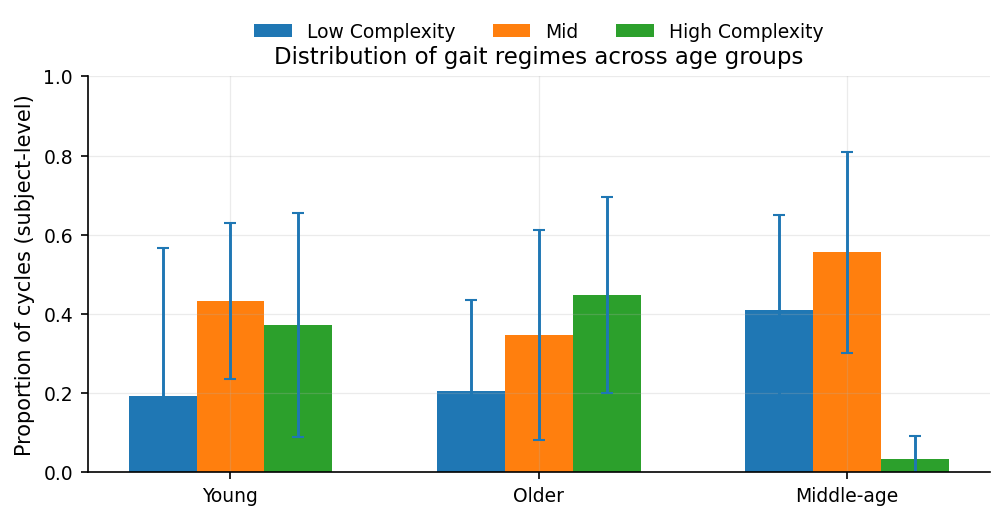

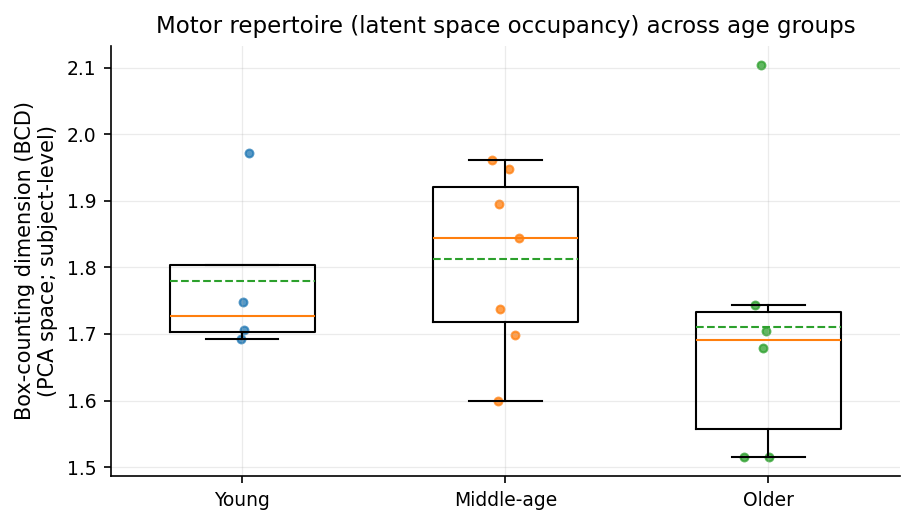

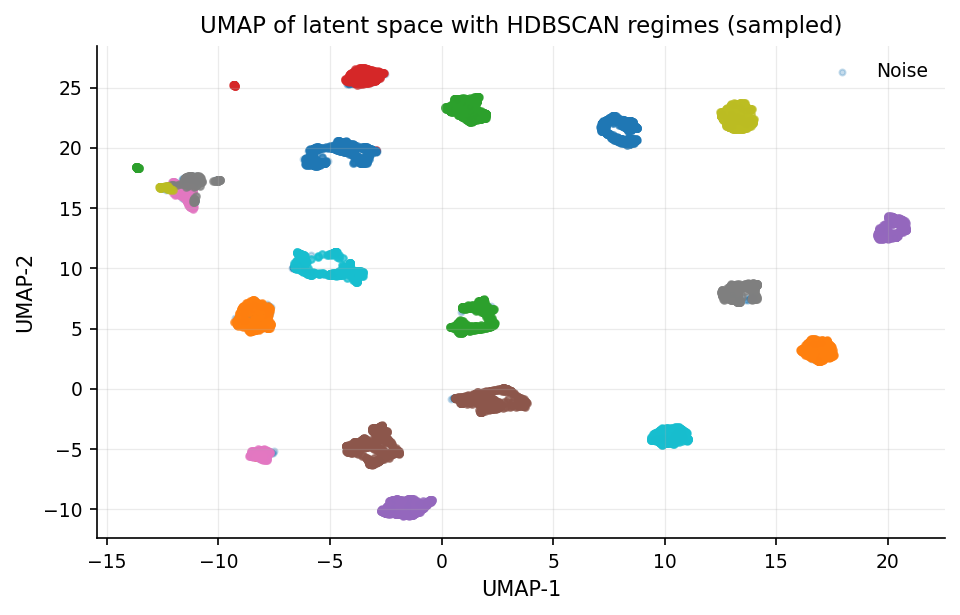

In [25]:
# Run and save
# =========================================================
# Example usage:
fig1 = fig_regime_proportions(df_subject_prop_piv, outpath="fig_regime_proportions.png")
fig2 = fig_bcd_by_group(df_bcd, outpath="fig_bcd_by_group.png")
fig3 = fig_umap_clusters(latents, labels_main, group_all=group_all, outpath="fig_umap_clusters.png")